READING AND FRAMING DATA (PM2.5 & PM 10) FROM FIDAS 200

In [3]:
import pandas as pd

#Load the FIDAS data
# Adjust the separator based on your file format: tab-delimited
df = pd.read_csv(
    'FIDAS_DATA.txt',
    sep='\t',
    header=0,
    dtype=str  #Load everything as string to ensure control over parsing
)

#Build a proper datetime column 
df['datetime'] = pd.to_datetime(
    df['date'].str.strip() + ' ' + df['time'].str.strip(),
    dayfirst=True,
    errors='coerce'
)

#Drop rows with invalid datetime
df.dropna(subset=['datetime'], inplace=True)

# Convert PM values to numeric 
df['pm25'] = pd.to_numeric(df['PM2.5'], errors='coerce')
df['pm10'] = pd.to_numeric(df['PM10'], errors='coerce')

# Drop rows with missing PM values
df.dropna(subset=['pm25', 'pm10'], inplace=True)

#Filter for July 7–9, 2025
mask = (df['datetime'] >= '2025-07-07') & (df['datetime'] < '2025-07-10')
df_subset = df.loc[mask].copy()

# Round down to hourly timestamps
df_subset['hour'] = df_subset['datetime'].dt.floor('h')

# Group by each hour and compute averages 
fidas = (
    df_subset
      .groupby('hour')[['pm25', 'pm10']]
      .mean()
      .rename(columns={'pm25': 'pm2.5_fidas', 'pm10': 'pm10_fidas'})
      .sort_index()
)

print(fidas)


                     pm2.5_fidas  pm10_fidas
hour                                        
2025-07-07 00:00:00     7.655551    9.162436
2025-07-07 01:00:00     8.691460   10.001117
2025-07-07 02:00:00     5.816341    6.941643
2025-07-07 03:00:00     6.920723    8.458798
2025-07-07 04:00:00     8.737209   10.831236
2025-07-07 05:00:00     5.360234    6.208059
2025-07-07 06:00:00     1.615807    1.911242
2025-07-07 07:00:00     2.043515    2.363016
2025-07-07 08:00:00     3.177291    3.600274
2025-07-07 09:00:00     5.566845    6.238856
2025-07-07 10:00:00     6.148773    7.506386
2025-07-07 11:00:00     5.480676    7.245462
2025-07-07 12:00:00     6.978047    9.495774
2025-07-07 13:00:00     8.420806   11.549124
2025-07-07 14:00:00    10.618623   13.510493
2025-07-07 15:00:00    12.587017   16.057449
2025-07-07 16:00:00     8.999057   11.396823
2025-07-07 17:00:00     9.856146   12.231314
2025-07-07 18:00:00    11.366491   13.231521
2025-07-07 19:00:00     9.364453   11.051777
2025-07-07

READING AND FRAMING DATA (PM2.5 & PM 10) FROM AIR QUALITY SENSOR (AQ_SENSOR)

In [4]:
import json
import pandas as pd

# Load the JSON file
with open("AQ_SENSOR_DATA.txt", "r") as f:
    data = json.load(f)

# Extract hourly records into a DataFrame
records = data["historical"]["hourly"]
df = pd.DataFrame([{
    "datetime": pd.to_datetime(rec["ts"]).tz_convert(None),
    "PM2.5_aqsensor": rec["pm25"]["conc"],
    "PM10_aqsensor": rec["pm10"]["conc"]
} for rec in records])

# Filter for July 7–9, 2025
mask = (df["datetime"] >= "2025-07-07") & (df["datetime"] < "2025-07-10")
df_filtered = df.loc[mask].copy()

# Round down to the hour and group
df_filtered["hour"] = df_filtered["datetime"].dt.floor("h")
hourly_avg = df_filtered.groupby("hour")[["PM2.5_aqsensor", "PM10_aqsensor"]].mean()

print(hourly_avg)


                     PM2.5_aqsensor  PM10_aqsensor
hour                                              
2025-07-07 10:00:00             8.0           12.0
2025-07-07 11:00:00             7.0           10.0
2025-07-07 12:00:00             9.0           15.0
2025-07-07 13:00:00            12.0           21.0
2025-07-07 14:00:00            17.0           29.0
2025-07-07 15:00:00            19.0           34.0
2025-07-07 16:00:00            14.0           24.0
2025-07-07 17:00:00            16.0           27.0
2025-07-07 18:00:00            19.0           31.0
2025-07-07 19:00:00            14.0           22.0
2025-07-07 20:00:00            12.0           18.0
2025-07-07 21:00:00            12.0           18.0
2025-07-07 22:00:00            12.0           20.0
2025-07-07 23:00:00            13.0           22.0
2025-07-08 00:00:00            15.0           23.0
2025-07-08 01:00:00            15.0           24.0
2025-07-08 02:00:00            18.0           28.0
2025-07-08 03:00:00            

MERGE THE HOURLY DATA (PM2.5 & PM10) FROM THE TWO INTRUMENTS

In [6]:
# Merge the data frames into a single data frame
daily_averages = fidas.join(hourly_avg, how='outer').sort_index()
print(daily_averages)

                     pm2.5_fidas  pm10_fidas  PM2.5_aqsensor  PM10_aqsensor
hour                                                                       
2025-07-07 00:00:00     7.655551    9.162436             NaN            NaN
2025-07-07 01:00:00     8.691460   10.001117             NaN            NaN
2025-07-07 02:00:00     5.816341    6.941643             NaN            NaN
2025-07-07 03:00:00     6.920723    8.458798             NaN            NaN
2025-07-07 04:00:00     8.737209   10.831236             NaN            NaN
2025-07-07 05:00:00     5.360234    6.208059             NaN            NaN
2025-07-07 06:00:00     1.615807    1.911242             NaN            NaN
2025-07-07 07:00:00     2.043515    2.363016             NaN            NaN
2025-07-07 08:00:00     3.177291    3.600274             NaN            NaN
2025-07-07 09:00:00     5.566845    6.238856             NaN            NaN
2025-07-07 10:00:00     6.148773    7.506386             8.0           12.0
2025-07-07 1

In [8]:
import matplotlib.pyplot as plt

# Drop rows where either sensor is NaN
df_clean = df.dropna(subset=['pm2.5_fidas', 'PM2.5_aqsensor'])

plt.figure(figsize=(6, 6))
plt.scatter(
    df_clean['pm2.5_fidas'],
    df_clean['PM2.5_aqsensor'],
    alpha=0.7,
    edgecolor='k'
)

# 1:1 identity line
min_val = min(df_clean['pm2.5_fidas'].min(), df_clean['PM2.5_aqsensor'].min())
max_val = max(df_clean['pm2.5_fidas'].max(), df_clean['PM2.5_aqsensor'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('PM2.5 (Fidas 200)')
plt.ylabel('PM2.5 (AQ Sensor)')
plt.title('PM2.5: Fidas 200 vs. AQ Sensor')
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: ['pm2.5_fidas']

In [34]:
# 1. See exactly what your DataFrame has
print(daily_averages.columns.tolist())

daily_averages = daily_averages.rename(columns={
    'pm2.5_fidas':      'pm25_fidas',
    'pm10_fidas':       'pm10_fidas',
    'PM2.5_aqsensor':   'pm25_aqsensor',
    'PM10_aqsensor':    'pm10_aqsensor'
})
print(daily_averages)


['pm25_fidas', 'pm10_fidas', 'pm25_aqsensor', 'pm10_aqsensor']
                     pm25_fidas  pm10_fidas  pm25_aqsensor  pm10_aqsensor
hour                                                                     
2025-07-07 00:00:00    7.655551    9.162436            NaN            NaN
2025-07-07 01:00:00    8.691460   10.001117            NaN            NaN
2025-07-07 02:00:00    5.816341    6.941643            NaN            NaN
2025-07-07 03:00:00    6.920723    8.458798            NaN            NaN
2025-07-07 04:00:00    8.737209   10.831236            NaN            NaN
2025-07-07 05:00:00    5.360234    6.208059            NaN            NaN
2025-07-07 06:00:00    1.615807    1.911242            NaN            NaN
2025-07-07 07:00:00    2.043515    2.363016            NaN            NaN
2025-07-07 08:00:00    3.177291    3.600274            NaN            NaN
2025-07-07 09:00:00    5.566845    6.238856            NaN            NaN
2025-07-07 10:00:00    6.148773    7.506386      

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel, wilcoxon
from statsmodels.api import OLS, add_constant


In [37]:
# strip whitespace, lower‐case, replace dots/spaces with underscores
daily_averages.columns = [
    col.strip()            # remove leading/trailing spaces
       .lower()            # all lower
       .replace('.', '')   # drop dots
       .replace(' ', '_')  # spaces→underscores
    for col in daily_averages.columns
]

print(daily_averages.columns.tolist())
# now you should see:
# ['pm25_fidas', 'pm10_fidas', 'pm25_aqsensor', 'pm10_aqsensor']


['pm25_fidas', 'pm10_fidas', 'pm25_aqsensor', 'pm10_aqsensor']


In [38]:
# Time‐Series Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, df['pm25_aqsensor'], label='PM2.5 AQ Sensor')
plt.plot(df.index, df['pm25_fidas'],     label='PM2.5 FIDAS')
plt.xlabel("Time")
plt.ylabel("Concentration (µg/m³)")
plt.title("Hourly PM2.5: AQ‐Sensor vs FIDAS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'pm25_aqsensor'

<Figure size 1000x500 with 0 Axes>

In [1]:
import pandas as pd

# 1. Read the FIDAS data file
#    Adjust sep='\t' if your file is tab-delimited; use sep=r'\s+' for whitespace.
df = pd.read_csv(
    'FIDAS_DATA.txt',
    sep='\t',
    header=0,
    dtype=str
)

# 2. Parse date and time into a single datetime column
df['datetime'] = pd.to_datetime(
    df['date'].str.strip() + ' ' + df['time'].str.strip(),
    dayfirst=True,
    errors='coerce'
)

# 3. Convert PM2.5 and PM10 to numeric
df['pm25'] = pd.to_numeric(df['PM2.5'], errors='coerce')
df['pm10'] = pd.to_numeric(df['PM10'],  errors='coerce')

# 4. Drop rows with invalid datetime or PM values
df = df.dropna(subset=['datetime', 'pm25', 'pm10'])

# 5. Filter to 7th, 8th, and 9th July 2025
mask = (df['datetime'] >= '2025-07-07') & (df['datetime'] < '2025-07-10')
df_sub = df.loc[mask].copy()

# 6. Compute average daily PM2.5 and PM10
df_sub['date'] = df_sub['datetime'].dt.date
daily_avg = df_sub.groupby('date')[['pm25', 'pm10']].mean()
# Rename the columns
daily_avg.rename(columns={
    'pm25': 'pm2.5_fidas',
    'pm10': 'pm10_fidas'
}, inplace=True)

print(daily_avg)


            pm2.5_fidas  pm10_fidas
date                               
2025-07-07     7.397111    9.085104
2025-07-08    11.200139   12.802236
2025-07-09    11.338413   12.577426


In [17]:
# merge the two data frames
df = daily.join(daily_avg)
print(df)


              pm25_aq    pm10_aq  pm2.5_fidas  pm10_fidas
timestamp                                                
2025-07-07  13.142857  21.642857     7.397111    9.085104
2025-07-08  17.583333  28.000000    11.200139   12.802236
2025-07-09  17.200000  26.500000    11.338413   12.577426


In [22]:
import pandas as pd
from scipy.stats import pearsonr
# Example df:
#             pm25_aq  pm10_aq  pm2.5_fidas  pm10_fidas
# date                                                
# 2025-07-07     11.3     18.5        7.40        9.09
# 2025-07-08     17.6     28.0       11.20       12.80

# 1. PM2.5 correlation
x25 = df['pm25_aq']
y25 = df['pm2.5_fidas']
r25, p25 = pearsonr(x25, y25)
r25_sq   = r25**2

# 2. PM10 correlation
x10 = df['pm10_aq']
y10 = df['pm10_fidas']
r10, p10 = pearsonr(x10, y10)
r10_sq   = r10**2

print(f"PM2.5 → Pearson r = {r25:.3f},  R² = {r25_sq:.3f},  p-value = {p25:.3f}")
print(f"PM10  → Pearson r = {r10:.3f},  R² = {r10_sq:.3f},  p-value = {p10:.3f}")


PM2.5 → Pearson r = 0.994,  R² = 0.988,  p-value = 0.069
PM10  → Pearson r = 0.985,  R² = 0.970,  p-value = 0.111


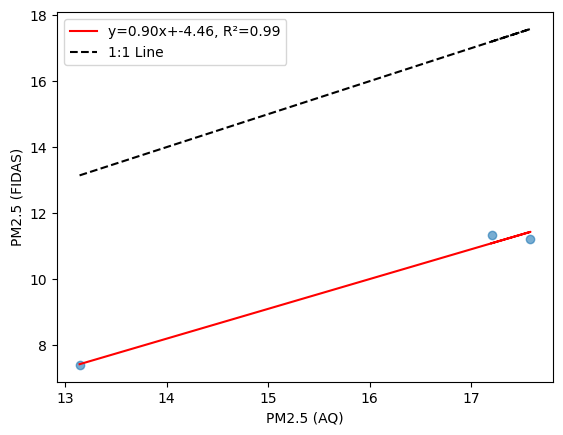

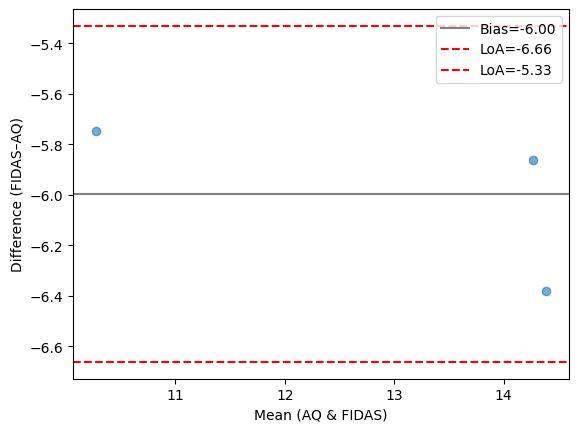

Pearson r=0.994, R²=0.988
Paired t-test: t=-30.588, p=0.001
Wilcoxon: W=0.000, p=0.250
Mean bias=-6.00, RMSE=6.00, NMB=-37.5%


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel, wilcoxon
import statsmodels.api as sm

# Assume df has columns: pm25_aq, pm25_fidas indexed by date or datetime

# 1. Scatter + OLS Regression
x, y = df['pm25_aq'], df['pm2.5_fidas']
slope, intercept = np.polyfit(x, y, 1)
r, _ = pearsonr(x, y)

# Plot
plt.scatter(x, y, alpha=0.6)
plt.plot(x, slope*x + intercept, 'r', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r**2:.2f}')
plt.plot(x, x, 'k--', label='1:1 Line')
plt.xlabel('PM2.5 (AQ)')
plt.ylabel('PM2.5 (FIDAS)')
plt.legend()
plt.show()

# 2. Bland–Altman
diff = y - x
mean = (x + y) / 2
bias, sd = diff.mean(), diff.std()
loa = (bias - 1.96*sd, bias + 1.96*sd)

plt.scatter(mean, diff, alpha=0.6)
plt.axhline(bias, color='gray', label=f'Bias={bias:.2f}')
plt.axhline(loa[0], color='red', linestyle='--', label=f'LoA={loa[0]:.2f}')
plt.axhline(loa[1], color='red', linestyle='--', label=f'LoA={loa[1]:.2f}')
plt.xlabel('Mean (AQ & FIDAS)')
plt.ylabel('Difference (FIDAS–AQ)')
plt.legend()
plt.show()

# 3. Statistical Tests
# Paired t-test
t_stat, p_t = ttest_rel(y, x)
# Wilcoxon signed-rank
w_stat, p_w = wilcoxon(y, x)

print(f"Pearson r={r:.3f}, R²={r**2:.3f}")
print(f"Paired t-test: t={t_stat:.3f}, p={p_t:.3f}")
print(f"Wilcoxon: W={w_stat:.3f}, p={p_w:.3f}")

# 4. Error Metrics
bias = (y - x).mean()
rmse = np.sqrt(((y - x)**2).mean())
nmb = 100 * bias / x.mean()

print(f"Mean bias={bias:.2f}, RMSE={rmse:.2f}, NMB={nmb:.1f}%")
